In [1]:
from src import PINNViga
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np
import json
import pandas as pd

EI = 1.0
q = 1.0 
L = 1.0

Epoch 0, Loss: 0.633361577988, PDE Loss: 0.614548027515, BC Loss: 0.018813548610
Epoch 100, Loss: 0.009798521176, PDE Loss: 0.006547172088, BC Loss: 0.003251349088
Epoch 200, Loss: 0.000120748547, PDE Loss: 0.000102023259, BC Loss: 0.000018725288
Epoch 300, Loss: 0.000032461685, PDE Loss: 0.000032407715, BC Loss: 0.000000053968
Epoch 400, Loss: 0.000025799860, PDE Loss: 0.000025776155, BC Loss: 0.000000023705
Epoch 500, Loss: 0.000021901018, PDE Loss: 0.000021891748, BC Loss: 0.000000009270
Epoch 600, Loss: 0.000018308194, PDE Loss: 0.000018294517, BC Loss: 0.000000013677
Epoch 700, Loss: 0.000016584067, PDE Loss: 0.000016580916, BC Loss: 0.000000003150
Epoch 800, Loss: 0.000015520243, PDE Loss: 0.000015517142, BC Loss: 0.000000003101
Epoch 900, Loss: 0.000014372687, PDE Loss: 0.000014315608, BC Loss: 0.000000057078
Epoch 1000, Loss: 0.000012689698, PDE Loss: 0.000012687469, BC Loss: 0.000000002229


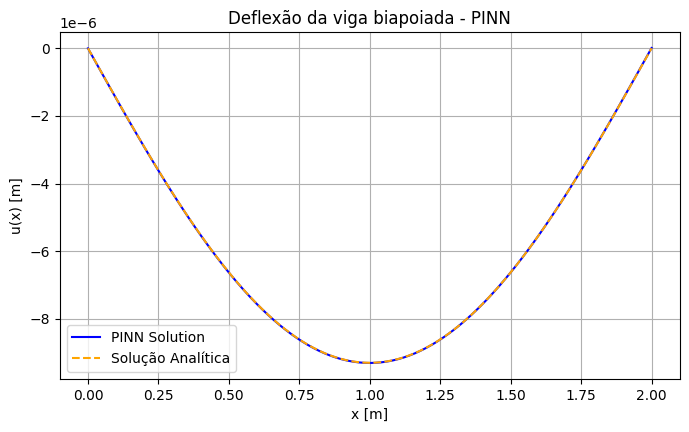

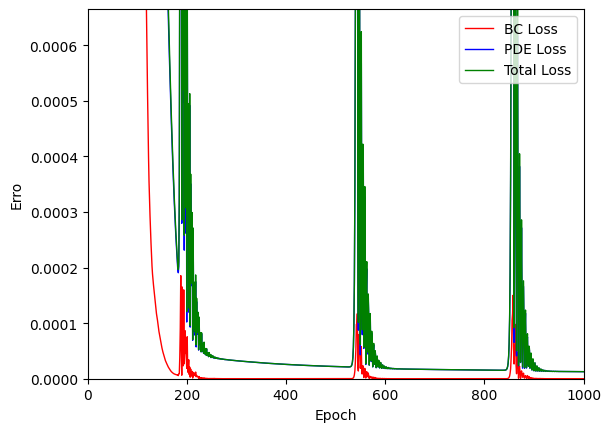

In [ ]:
## VIGA BIAPOIADA

b = 0.2
h = 0.4
E = 210e9
I = b * (h ** 3) / 12
EI = E * I
q = -10e3
L = 2

apoio_esq = [1, 1, 0]
apoio_dir = [0, 1, 0]

biapoiada = PINNViga.PINNViga()
biapoiada.run_model(apoio_esq, apoio_dir, EI, q, L, num_epochs=1000, pde_weight=1, bc_weight=1, tol = 1e-5)

def y_calc(x_val): 
    return (q * x_val / (24 * EI)) * (L**3 - 2 * L * x_val**2 + x_val**3)

plt.figure(figsize=(8, 4.5))
plt.plot(biapoiada.x_plot, biapoiada.u_plot, label='PINN Solution', color='blue')
plt.plot(biapoiada.x_plot, y_calc(biapoiada.x_plot), label='Solução Analítica', linestyle='dashed', color='orange')
plt.title("Deflexão da viga biapoiada - PINN")
plt.xlabel("x [m]")
plt.ylabel("u(x) [m]")
plt.grid(True)
plt.legend()
plt.show()

biapoiada.plot_errors(1000)

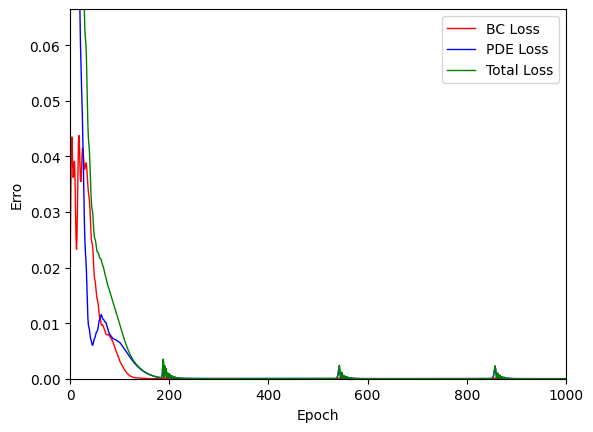

In [3]:
biapoiada.plot_errors(10)

Epoch 0, Loss: 0.633361577988, PDE Loss: 0.614548027515, BC Loss: 0.018813548610
Epoch 100, Loss: 0.009798521176, PDE Loss: 0.006547172088, BC Loss: 0.003251349088
Epoch 200, Loss: 0.000120748547, PDE Loss: 0.000102023259, BC Loss: 0.000018725288
Epoch 300, Loss: 0.000032461685, PDE Loss: 0.000032407715, BC Loss: 0.000000053968
Epoch 400, Loss: 0.000025799860, PDE Loss: 0.000025776155, BC Loss: 0.000000023705
Epoch 500, Loss: 0.000021901018, PDE Loss: 0.000021891748, BC Loss: 0.000000009270
Epoch 600, Loss: 0.000018308194, PDE Loss: 0.000018294517, BC Loss: 0.000000013677
Epoch 700, Loss: 0.000016584067, PDE Loss: 0.000016580916, BC Loss: 0.000000003150
Epoch 800, Loss: 0.000015520243, PDE Loss: 0.000015517142, BC Loss: 0.000000003101
Epoch 900, Loss: 0.000014372687, PDE Loss: 0.000014315608, BC Loss: 0.000000057078
Epoch 1000, Loss: 0.000012689698, PDE Loss: 0.000012687469, BC Loss: 0.000000002229


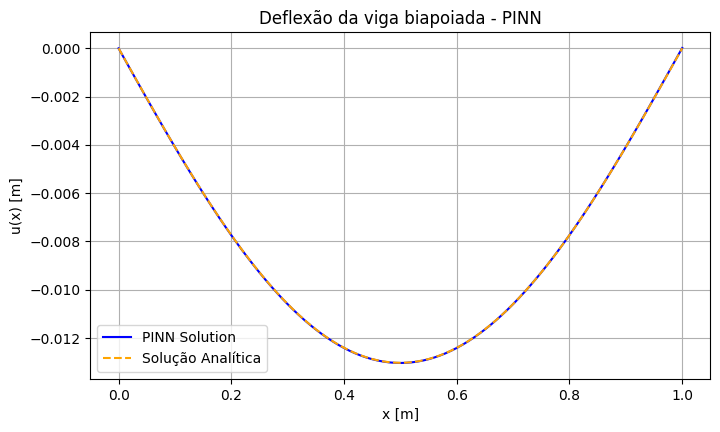

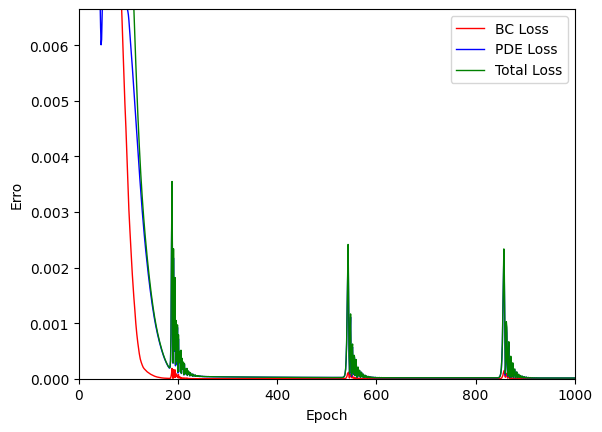

In [26]:
EI = 1.0
q = - 1.0 
L = 1.0

apoio_esq = [1, 1, 0]
apoio_dir = [0, 1, 0]

biapoiada = PINNViga.PINNViga()
biapoiada.run_model(apoio_esq, apoio_dir, EI, q, L, num_epochs=1000, pde_weight=1, bc_weight=1, tol = 1e-5)

def y_calc(x_val): 
    return (q * x_val / (24 * EI)) * (L**3 - 2 * L * x_val**2 + x_val**3)

plt.figure(figsize=(8, 4.5))
plt.plot(biapoiada.x_plot, biapoiada.u_plot, label='PINN Solution', color='blue')
plt.plot(biapoiada.x_plot, y_calc(biapoiada.x_plot), label='Solução Analítica', linestyle='dashed', color='orange')
plt.title("Deflexão da viga biapoiada - PINN")
plt.xlabel("x [m]")
plt.ylabel("u(x) [m]")
plt.grid(True)
plt.legend()
plt.show()

biapoiada.plot_errors(100)

C:\Users\Tácio\AppData\Local\Temp\ipykernel_19452\2722399630.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


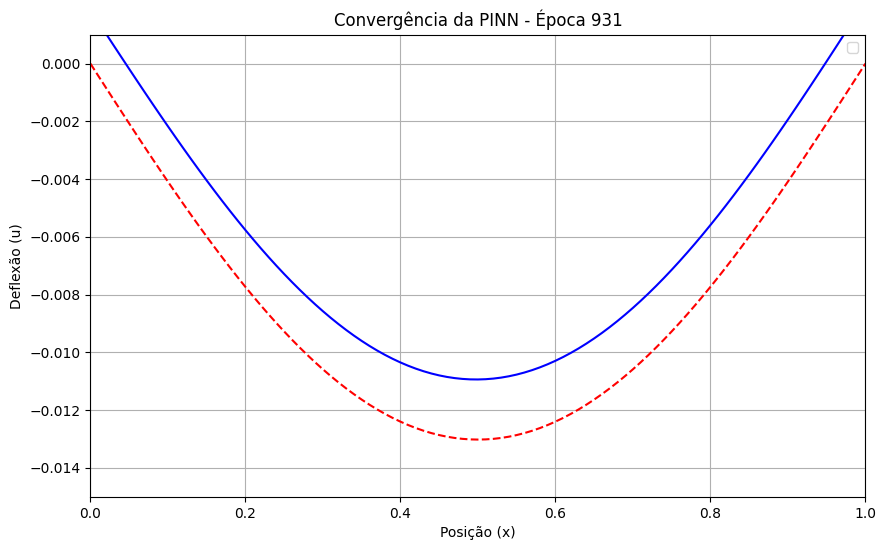

In [12]:
# fig, ax = plt.subplots(figsize=(10, 6))

# ax.set_title("Convergência da PINN")
# ax.set_xlabel("Posição (x)")
# ax.set_ylabel("Deflexão (u)")
# ax.grid(True)
# ax.set_xlim(0, 1)
# ax.set_ylim(-0.015, 0.001)
# ax.legend()

# line_pinn, = ax.plot([], [], 'b-', label='Solução PINN')
# line_analytic, = ax.plot(biapoiada.x_plot, y_calc(biapoiada.x_plot), 'r--', label='Solução Analítica')

# def animate(i):

#     epoch, u_pinn = biapoiada.u_plot_variation[i]
#     line_pinn.set_data(biapoiada.x_plot, u_pinn)
#     ax.set_title(f"Convergência da PINN - Época {epoch}")
    
#     return line_pinn,

# anim = FuncAnimation(fig, animate, frames=len(biapoiada.u_plot_variation), interval=50, blit=True)
# writer = PillowWriter(fps=30)
# anim.save("teste2_biapoiada_epoch_640_bc_1.gif", writer=writer)

# plt.show()

Epoch 0, Loss: 0.631187975407, PDE Loss: 0.614548027515, BC Loss: 0.016639944166
Epoch 100, Loss: 0.008527137339, PDE Loss: 0.005074478686, BC Loss: 0.003452659119
Epoch 200, Loss: 0.001722724526, PDE Loss: 0.001627779799, BC Loss: 0.000094944764
Epoch 300, Loss: 0.000095596908, PDE Loss: 0.000092885173, BC Loss: 0.000002711738
Epoch 400, Loss: 0.000031099546, PDE Loss: 0.000030417530, BC Loss: 0.000000682014
Epoch 500, Loss: 0.000021795080, PDE Loss: 0.000021773960, BC Loss: 0.000000021120
Epoch 600, Loss: 0.000018261537, PDE Loss: 0.000018245093, BC Loss: 0.000000016444
Epoch 700, Loss: 0.000016265703, PDE Loss: 0.000016248481, BC Loss: 0.000000017222
Epoch 800, Loss: 0.000014417754, PDE Loss: 0.000014412291, BC Loss: 0.000000005463
Epoch 900, Loss: 0.000049992290, PDE Loss: 0.000046211608, BC Loss: 0.000003780681
Epoch 1000, Loss: 0.000012167386, PDE Loss: 0.000012163249, BC Loss: 0.000000004136


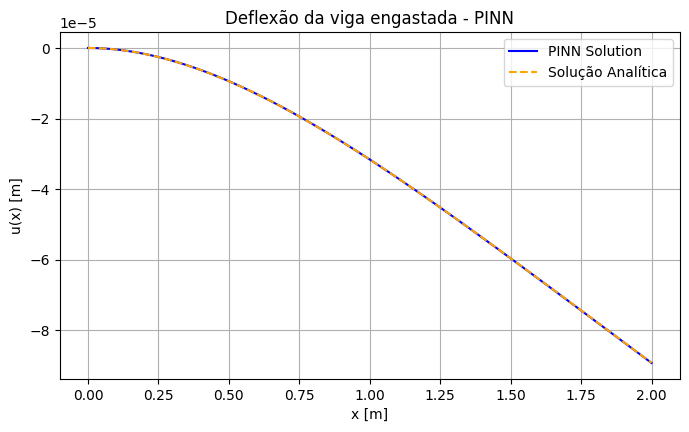

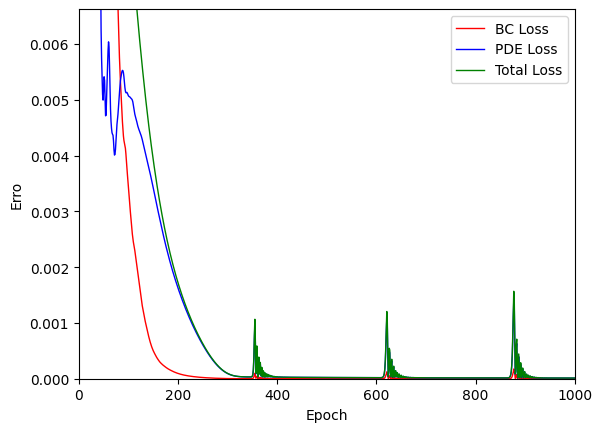

In [7]:
## VIGA ENGASTADA

apoio_esq = [1, 1, 1]
apoio_dir = [0, 0, 0]

EI = 1.0
q = - 1.0 
L = 1.0

b = 0.2
h = 0.4
E = 210e9
I = b * (h ** 3) / 12
EI = E * I
q = -10e3
L = 2

engastada = PINNViga.PINNViga()
engastada.run_model(apoio_esq, apoio_dir, EI, q, L, num_epochs=1000, pde_weight=1, bc_weight=1, tol = 1e-6)

def y_calc2(x): 
    # return  (q * (x ** 2)/ (24 * EI)) * (6 * L ** 2 + x ** 2)
    return (q * (x ** 2) / (24 * EI)) * (6 * L ** 2 - 4 * L * x + x ** 2)

plt.figure(figsize=(8, 4.5))
plt.plot(engastada.x_plot, engastada.u_plot, label='PINN Solution', color='blue')
plt.plot(engastada.x_plot, y_calc2(engastada.x_plot), label='Solução Analítica', linestyle='dashed', color='orange')
plt.title("Deflexão da viga engastada - PINN")
plt.xlabel("x [m]")
plt.ylabel("u(x) [m]")
plt.grid(True)
plt.legend()
plt.show()

engastada.plot_errors(100)

C:\Users\Tácio\AppData\Local\Temp\ipykernel_4104\521982417.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


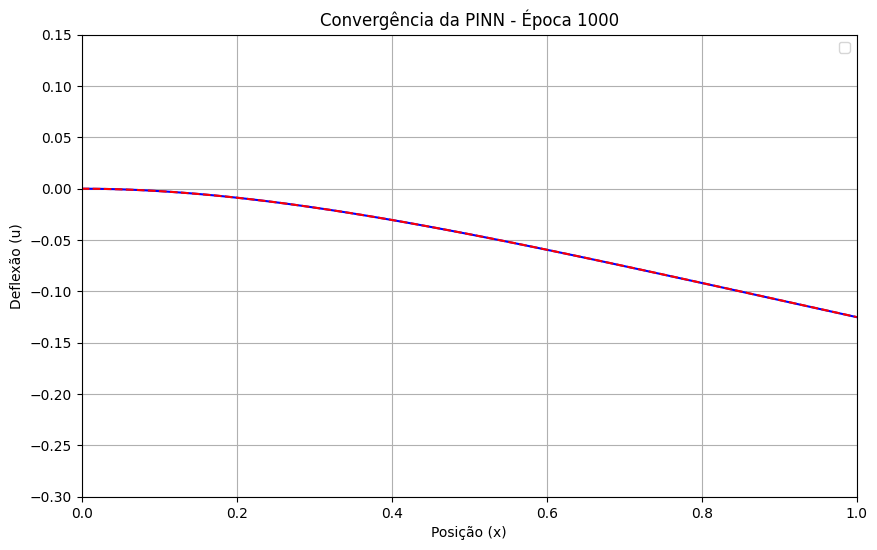

In [6]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.set_title("Convergência da PINN")
ax.set_xlabel("Posição (x)")
ax.set_ylabel("Deflexão (u)")
ax.grid(True)
ax.set_xlim(0, 1)
ax.set_ylim(-0.3, 0.15)
# ax.set_ylim(-0.015, 0.001)
ax.legend()

line_pinn, = ax.plot([], [], 'b-', label='Solução PINN')
line_analytic, = ax.plot(engastada.x_plot, y_calc2(engastada.x_plot), 'r--', label='Solução Analítica')

def animate(i):

    epoch, u_pinn = engastada.u_plot_variation[i]
    line_pinn.set_data(engastada.x_plot, u_pinn)
    ax.set_title(f"Convergência da PINN - Época {epoch}")
    
    return line_pinn,

anim = FuncAnimation(fig, animate, frames=len(engastada.u_plot_variation), interval=50, blit=True)
writer = PillowWriter(fps=30)
anim.save("engastada_epoch_500_bc_1.gif", writer=writer)

plt.show()